In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import nltk
from nltk.corpus import stopwords
import re
import spacy
from collections import Counter
from xgboost import XGBClassifier


In [2]:
nltk.download('stopwords')

spacy.cli.download("fr_core_news_sm")

nlp = spacy.load('fr_core_news_sm')

file_path = 'projetintegrer.csv'
data = pd.read_csv(file_path)

stop_words = set(stopwords.words('french'))

#clean text
def clean_text(tokens):
    #eemove punctuation and special characters
    tokens = [re.sub(r'\W+', '', token) for token in tokens]
    #convert to lowercase
    tokens = [token.lower() for token in tokens]
    #remove stopwords
    tokens = [token for token in tokens if token not in stop_words]
    #lemmatize using spaCy
    doc = nlp(' '.join(tokens))
    tokens = [token.lemma_ for token in doc]
    #remove short words
    tokens = [token for token in tokens if len(token) > 2]
    return tokens

#apply cleaning function 
data['Cleaned_Tokens'] = data['Tokenized'].apply(lambda x: clean_text(eval(x)))

#flatten the list of tokens to create a single list of all words
all_words = [word for tokens in data['Cleaned_Tokens'] for word in tokens]

#falculate the frequency of each word
word_freq = Counter(all_words)

#define a threshold for rare words (e.g., words that appear less than 5 times)
threshold = 5

#create a set of rare words
rare_words = {word for word, freq in word_freq.items() if freq < threshold}

#function to remove rare words from tokenized text
def remove_rare_words(tokens):
    return [token for token in tokens if token not in rare_words]

#apply the function to remove rare words
data['Cleaned_Tokens'] = data['Cleaned_Tokens'].apply(remove_rare_words)
data['Cleaned_Text'] = data['Cleaned_Tokens'].apply(lambda x: ' '.join(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
import numpy as np
np.random.seed(42)
data['Sentiment'] = np.random.choice([0, 1], size=len(data))
#split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['Cleaned_Text'], data['Sentiment'], test_size=0.2, random_state=42)

#adjusting the TF-IDF vectorizer parameters
vectorizer = TfidfVectorizer(
    max_features=5000,  
    ngram_range=(1, 2),  
    max_df=0.95,
    min_df=2
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [5]:
!pip install smote
!pip install imbalanced-learn
!pip install GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline

ERROR: Could not find a version that satisfies the requirement GridSearchCV (from versions: none)
ERROR: No matching distribution found for GridSearchCV


In [8]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)
print(data.columns)

Index(['Text', 'Tokenized', 'Cleaned_Tokens', 'Cleaned_Text', 'Sentiment'], dtype='object')


In [12]:
#TextBlob Classification

from textblob import TextBlob

def classify_sentiment_textblob(text):
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity
    if polarity >= 0.7:
        return 3  # Hyper-positive
    elif polarity > 0.1:
        return 2  # Positive
    elif polarity > -0.1:
        return 1  # Neutral
    elif polarity > -0.7:
        return 0  # Negative
    else:
        return 4 #Hyper-negative
    
data['Sentiment'] = data['Cleaned_Tokens'].apply(lambda x: classify_sentiment_textblob(' '.join(eval(x))))

data.to_csv('data1.csv', index=False)

print(data.head())

                                                Text  \
0                                    lord god angels   
1  blessings iv hated needles young strong im for...   
2  stage 4 small cell stage 5 3 1 2 years took 16...   
3                                      get well soon   
4                                      get well soon   

                                           Tokenized  \
0                          ['lord', 'god', 'angels']   
1  ['blessings', 'iv', 'hated', 'needles', 'young...   
2  ['stage', 'small', 'cell', 'stage', 'years', '...   
3                            ['get', 'well', 'soon']   
4                            ['get', 'well', 'soon']   

                                      Cleaned_Tokens  Sentiment  
0                           ['lord', 'god', 'angel']          1  
1  ['blessing', 'hated', 'needle', 'young', 'stro...          2  
2  ['stage', 'small', 'cell', 'stage', 'year', 't...          2  
3                            ['get', 'well', 'soon']          

In [13]:
#Vadeer distribution
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from imblearn.over_sampling import SMOTE

file_path = 'projetintegrer.csv'
data = pd.read_csv(file_path)


analyzer = SentimentIntensityAnalyzer()

def classify_sentiment_vader(text):
    score = analyzer.polarity_scores(text)
    if score['compound'] >= 0.7:
        return 3 #++++positive
    elif score['compound'] > 0.1:
        return 2 #positive
    elif score['compound'] > -0.1:
        return 1 #neutral
    elif score['compound'] > -0.7:
        return 0 #neg
    else:
        return 4 #++++++++++++neg
    
data['Sentiment'] = data['Cleaned_Tokens'].apply(lambda x: classify_sentiment_vader(' '.join(eval(x))))

data.to_csv('data2.csv', index=False)

print(data.head())


                                                Text  \
0                                    lord god angels   
1  blessings iv hated needles young strong im for...   
2  stage 4 small cell stage 5 3 1 2 years took 16...   
3                                      get well soon   
4                                      get well soon   

                                           Tokenized  \
0                          ['lord', 'god', 'angels']   
1  ['blessings', 'iv', 'hated', 'needles', 'young...   
2  ['stage', 'small', 'cell', 'stage', 'years', '...   
3                            ['get', 'well', 'soon']   
4                            ['get', 'well', 'soon']   

                                      Cleaned_Tokens  Sentiment  
0                           ['lord', 'god', 'angel']          2  
1  ['blessing', 'hated', 'needle', 'young', 'stro...          3  
2  ['stage', 'small', 'cell', 'stage', 'year', 't...          3  
3                            ['get', 'well', 'soon']          

           Count  Proportion
Sentiment                   
0            104    0.055026
1            612    0.323810
2           1005    0.531746
3            158    0.083598
4             11    0.005820


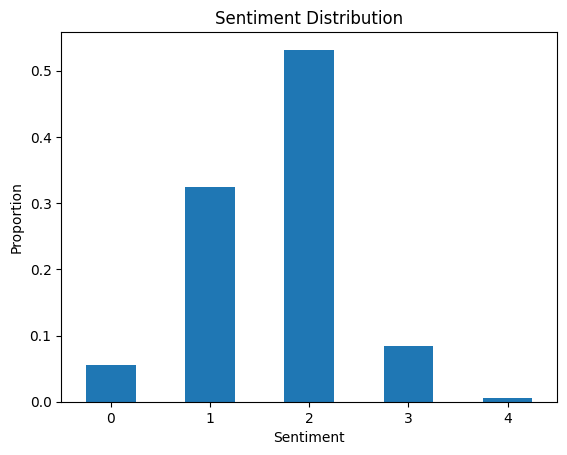

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
#textblob distribution
file_path = 'data1.csv'
data = pd.read_csv(file_path)

sentiment_counts = data['Sentiment'].value_counts().sort_index()
sentiment_proportions = sentiment_counts / len(data)
sentiment_summary = pd.DataFrame({
    'Count': sentiment_counts,
    'Proportion': sentiment_proportions
})
print(sentiment_summary)

#textblob distribution
sentiment_summary.plot(kind='bar', y='Proportion', legend=False)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.show()

           Count  Proportion
Sentiment                   
0            172    0.091005
1            229    0.121164
2            516    0.273016
3            877    0.464021
4             96    0.050794


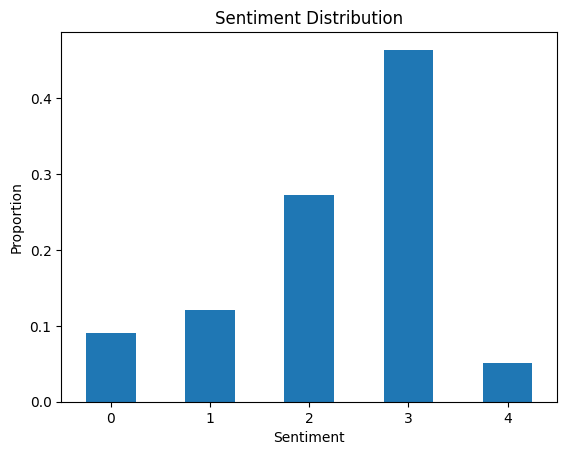

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
#vadeer distribution
file_path = 'data2.csv'
data = pd.read_csv(file_path)

sentiment_counts = data['Sentiment'].value_counts().sort_index()
sentiment_proportions = sentiment_counts / len(data)
sentiment_summary = pd.DataFrame({
    'Count': sentiment_counts,
    'Proportion': sentiment_proportions
})
print(sentiment_summary)

#vadeer distribution
sentiment_summary.plot(kind='bar', y='Proportion', legend=False)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.show()

We are going to choose TextBlob Distribution

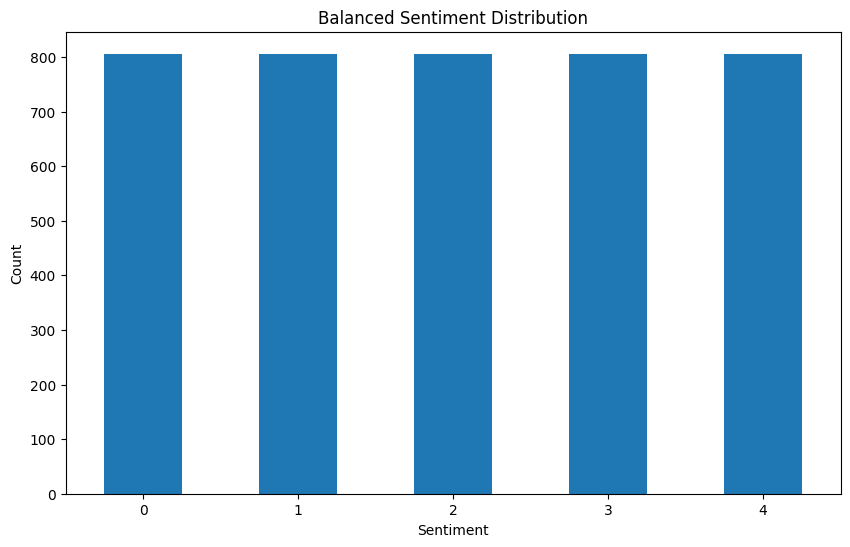

In [20]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

file_path = 'data1.csv'
data = pd.read_csv(file_path)

data['Cleaned_Tokens'] = data['Cleaned_Tokens'].apply(eval)

X = data['Cleaned_Tokens'].apply(lambda x: ' '.join(x))
y = data['Sentiment']

#Tf-idf
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

#split data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# display the distribution
balanced_counts = pd.Series(y_train_balanced).value_counts().sort_index()


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
balanced_counts.plot(kind='bar')
plt.title('Balanced Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

#train the model random forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train_balanced, y_train_balanced)
rf_predictions = rf_model.predict(X_test)

#ecaluate the model
print("Random Forest Accuracy:", accuracy_score(y_test, rf_predictions))
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_predictions))

Random Forest Accuracy: 0.791005291005291
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.11      0.15        18
           1       0.75      0.87      0.80       136
           2       0.86      0.83      0.85       199
           3       0.67      0.61      0.64        23
           4       0.00      0.00      0.00         2

    accuracy                           0.79       378
   macro avg       0.51      0.48      0.49       378
weighted avg       0.78      0.79      0.78       378



c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

#train the model
nb_model = MultinomialNB()
nb_model.fit(X_train_balanced, y_train_balanced)
nb_predictions = nb_model.predict(X_test)

# evaluate the Naive Bayes model
print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_predictions))
print("Naive Bayes Classification Report:")
print(classification_report(y_test, nb_predictions))

Naive Bayes Accuracy: 0.656084656084656
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.72      0.41        18
           1       0.85      0.44      0.58       136
           2       0.80      0.80      0.80       199
           3       0.31      0.70      0.43        23
           4       0.00      0.00      0.00         2

    accuracy                           0.66       378
   macro avg       0.45      0.53      0.44       378
weighted avg       0.76      0.66      0.68       378



In [23]:
from xgboost import XGBClassifier

#train the model
xgb_model = XGBClassifier()
xgb_model.fit(X_train_balanced, y_train_balanced)
xgb_predictions = xgb_model.predict(X_test)

#evaluation
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_predictions))
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_predictions))

XGBoost Accuracy: 0.8148148148148148
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.33      0.38        18
           1       0.79      0.86      0.82       136
           2       0.88      0.85      0.87       199
           3       0.68      0.65      0.67        23
           4       0.00      0.00      0.00         2

    accuracy                           0.81       378
   macro avg       0.56      0.54      0.55       378
weighted avg       0.81      0.81      0.81       378



In [24]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Train an SVM model
svm_model = SVC()
svm_model.fit(X_train_balanced, y_train_balanced)
svm_predictions = svm_model.predict(X_test)

# Evaluate the SVM model
print("SVM Accuracy:", accuracy_score(y_test, svm_predictions))
print("SVM Classification Report:")
print(classification_report(y_test, svm_predictions))

SVM Accuracy: 0.8015873015873016
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.06      0.10        18
           1       0.80      0.82      0.81       136
           2       0.80      0.92      0.86       199
           3       1.00      0.30      0.47        23
           4       0.00      0.00      0.00         2

    accuracy                           0.80       378
   macro avg       0.62      0.42      0.45       378
weighted avg       0.79      0.80      0.78       378



c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Train a Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train_balanced, y_train_balanced)
logreg_predictions = logreg_model.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, logreg_predictions)
report = classification_report(y_test, logreg_predictions)

print("Logistic Regression Accuracy:", accuracy)
print("Logistic Regression Classification Report:")
print(report)

Logistic Regression Accuracy: 0.7751322751322751
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.28      0.33        18
           1       0.71      0.85      0.77       136
           2       0.88      0.81      0.85       199
           3       0.65      0.48      0.55        23
           4       0.00      0.00      0.00         2

    accuracy                           0.78       378
   macro avg       0.53      0.48      0.50       378
weighted avg       0.78      0.78      0.77       378



In [26]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

gbm_model = GradientBoostingClassifier()
gbm_model.fit(X_train_balanced, y_train_balanced)
gbm_predictions = gbm_model.predict(X_test)

#evaluate the Gradient Boosting model
accuracy = accuracy_score(y_test, gbm_predictions)
report = classification_report(y_test, gbm_predictions)

print("Gradient Boosting Accuracy:", accuracy)
print("Gradient Boosting Classification Report:")
print(report)

Gradient Boosting Accuracy: 0.791005291005291
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.39      0.47        18
           1       0.73      0.91      0.81       136
           2       0.91      0.76      0.83       199
           3       0.53      0.70      0.60        23
           4       0.00      0.00      0.00         2

    accuracy                           0.79       378
   macro avg       0.55      0.55      0.54       378
weighted avg       0.80      0.79      0.79       378



c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


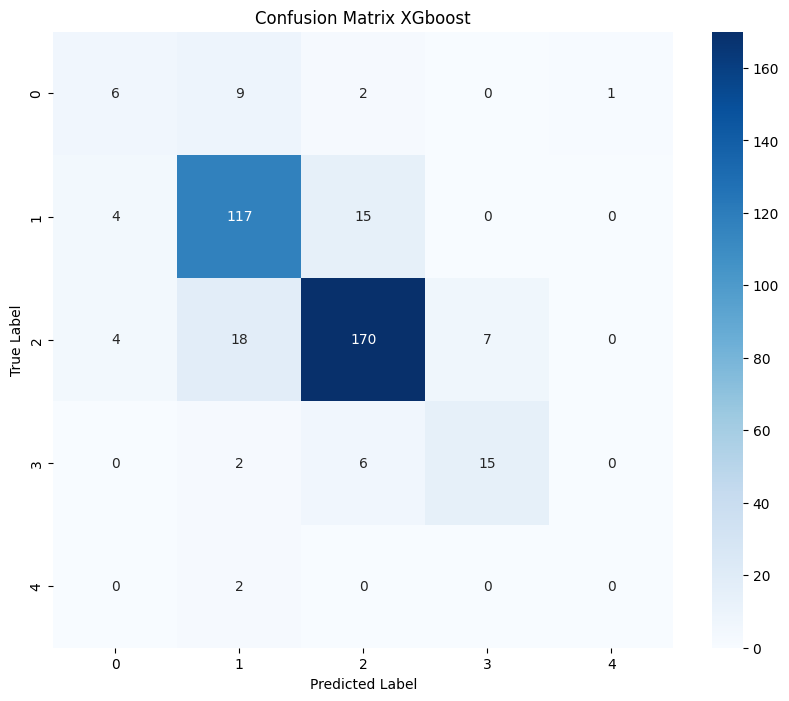

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test, xgb_predictions, labels=xgb_model.classes_)

cm_df = pd.DataFrame(cm, index=xgb_model.classes_, columns=xgb_model.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix XGboost')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

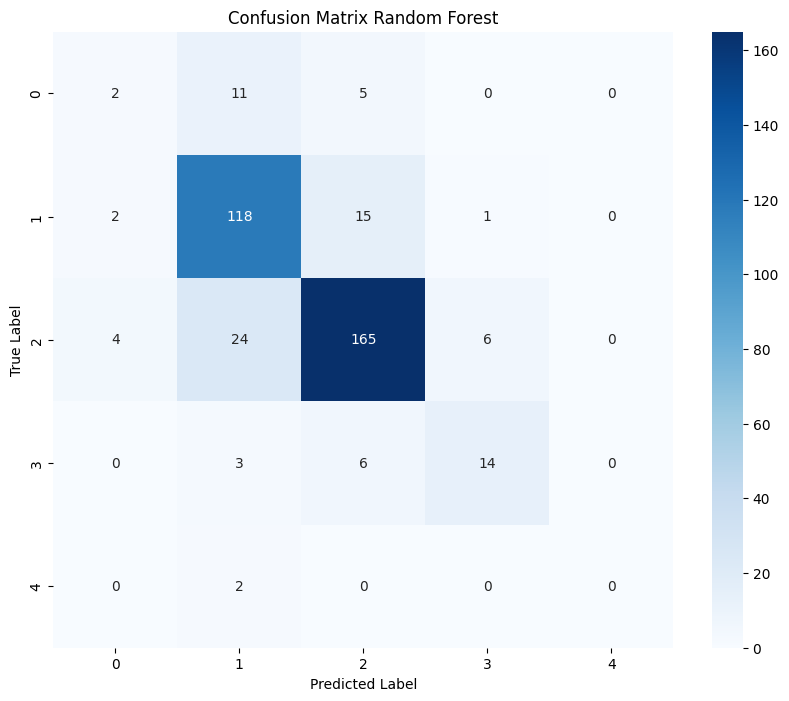

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test, rf_predictions, labels=rf_model.classes_)

cm_df = pd.DataFrame(cm, index=rf_model.classes_, columns=rf_model.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

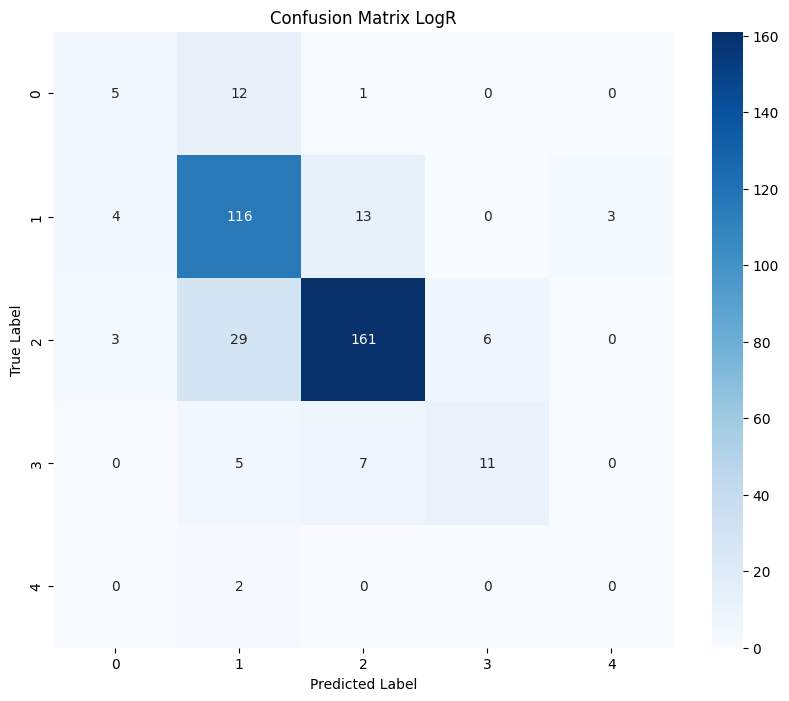

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test, logreg_predictions, labels=logreg_model.classes_)

cm_df = pd.DataFrame(cm, index=logreg_model.classes_, columns=logreg_model.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix LogR')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

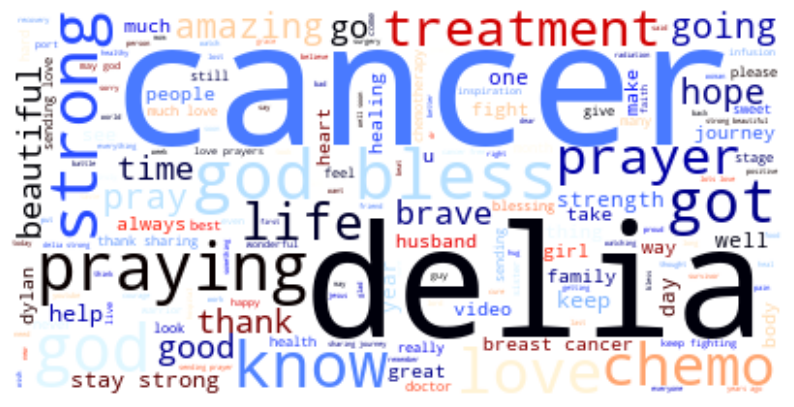

In [45]:
import numpy as np
from wordcloud import STOPWORDS, WordCloud
import matplotlib.pyplot as plt

df = pd.read_csv('projetintegrer.csv')

text = df['Text'].str.cat(sep=' ')
stopwords = set(STOPWORDS)
new_words = ('delia')
new_stopwords = stopwords.union(new_words)
#size 
plt.rcParams["figure.figsize"] = (10, 10)
#wordcloud
wordcloud = WordCloud(max_font_size=90, max_words=1000, background_color="white", stopwords=new_stopwords, colormap='flag').generate(text)
#plot it
plt.plot()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()